<a href="https://colab.research.google.com/github/GuevaraMarcos/TelecomX2/blob/main/TelecomX%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge Telecom X: análisis de evasión de clientes - Parte 2

In [20]:
# Importación de librerías necesarias
import pandas as pd
pd.set_option('display.max_columns', None) # Mostrar todas las columnas de los DataFrames

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # Ignorar advertencias

# Librerías para preprocesamiento
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Librerías para modelado y evaluación
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from xgboost import plot_importance

import pickle # Para guardar modelos

# Cargar los datos desde el archivo especificado
try:
    datos = pd.read_csv('/content/data_preprocesada.csv')
    print("Archivo 'data_preprocesada.csv' cargado exitosamente.")
    # Mostrar las primeras filas y la información del DataFrame
    print("\nPrimeras 5 filas del DataFrame:")
    display(datos.head())
    print("\nInformación del DataFrame:")
    datos.info()
except FileNotFoundError:
    print("Error: El archivo 'data_preprocesada.csv' no se encuentra en '/content/'.")
    print("Asegúrate de que el archivo esté subido a tu entorno de Colab.")
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")

Archivo 'data_preprocesada.csv' cargado exitosamente.

Primeras 5 filas del DataFrame:


,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,Churn
0,0,Male,0,1,No,No phone service,Fiber optic,No,No,No,No,Yes,No,Two year,No,Electronic check,No,0
1,1,Female,1,0,No,No phone service,DSL,Yes,Yes,No,No internet service,Yes,No,Two year,No,Bank transfer (automatic),No,1
2,2,Male,1,0,No,No phone service,DSL,No,No,No,No,No,Yes,Two year,Yes,Bank transfer (automatic),No,1
3,3,Male,1,0,No,Yes,No,Yes,Yes,No internet service,No,No,No,Month-to-month,Yes,Credit card (automatic),Yes,1
4,4,Male,1,0,Yes,Yes,No,No,No,Yes,Yes,No,Yes,Two year,Yes,Electronic check,No,0



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        1000 non-null   int64 
 1   gender            1000 non-null   object
 2   Partner           1000 non-null   int64 
 3   Dependents        1000 non-null   int64 
 4   PhoneService      1000 non-null   object
 5   MultipleLines     1000 non-null   object
 6   InternetService   1000 non-null   object
 7   OnlineSecurity    1000 non-null   object
 8   OnlineBackup      1000 non-null   object
 9   DeviceProtection  1000 non-null   object
 10  TechSupport       1000 non-null   object
 11  StreamingTV       1000 non-null   object
 12  StreamingMovies   1000 non-null   object
 13  Contract          1000 non-null   object
 14  PaperlessBilling  1000 non-null   object
 15  PaymentMethod     1000 non-null   object
 16  SeniorCitizen     1000 non-null  

### Codificación de Variables Categóricas (One-Hot Encoding)

Transformamos las variables categóricas a un formato numérico binario para que sean compatibles con los algoritmos de Machine Learning.

In [21]:
# Identificación de columnas categóricas (excluyendo la columna objetivo 'Churn' y 'customerID')
# Nos basamos en el dtype 'object' de datos.info()
categorical_features = [col for col in datos.columns if datos[col].dtype == 'object' and col != 'Churn']

# Crear el transformador OneHotEncoder
# handle_unknown='ignore' permite manejar categorías no vistas durante el entrenamiento
# remainder='passthrough' mantiene las columnas numéricas originales (como 'customerID' y 'Churn')
encoder_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    remainder='passthrough'
)

# Aplicar la transformación a los datos
encoded_data = encoder_transformer.fit_transform(datos)

# Crear un nuevo DataFrame con los datos codificados
# Obtenemos los nombres de las columnas transformadas
encoded_columns = encoder_transformer.get_feature_names_out()
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Mostrar las primeras filas y la información del DataFrame codificado
print("DataFrame después de One-Hot Encoding:")
display(encoded_df.head())

print("\nInformación general del DataFrame codificado:")
encoded_df.info()

DataFrame después de One-Hot Encoding:


,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__PhoneService_No,onehotencoder__PhoneService_Yes,onehotencoder__MultipleLines_No,onehotencoder__MultipleLines_No phone service,onehotencoder__MultipleLines_Yes,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__OnlineSecurity_No,onehotencoder__OnlineSecurity_No internet service,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_No,onehotencoder__OnlineBackup_No internet service,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_No,onehotencoder__DeviceProtection_No internet service,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_No,onehotencoder__TechSupport_No internet service,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_No,onehotencoder__StreamingTV_No internet service,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_No,onehotencoder__StreamingMovies_No internet service,onehotencoder__StreamingMovies_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__SeniorCitizen_No,onehotencoder__SeniorCitizen_Yes,remainder__customerID,remainder__Partner,remainder__Dependents,remainder__Churn
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0



Información general del DataFrame codificado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 43 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   onehotencoder__gender_Female                            1000 non-null   float64
 1   onehotencoder__gender_Male                              1000 non-null   float64
 2   onehotencoder__PhoneService_No                          1000 non-null   float64
 3   onehotencoder__PhoneService_Yes                         1000 non-null   float64
 4   onehotencoder__MultipleLines_No                         1000 non-null   float64
 5   onehotencoder__MultipleLines_No phone service           1000 non-null   float64
 6   onehotencoder__MultipleLines_Yes                        1000 non-null   float64
 7   onehotencoder__InternetService_DSL                      1000 non-null   float

In [22]:
# Separar las variables predictoras (X) de la variable objetivo (y)
# La columna 'remainder__Churn' es nuestra variable objetivo
y = encoded_df['remainder__Churn']
X = encoded_df.drop('remainder__Churn', axis=1)

# Verificar las dimensiones de los conjuntos X e y
print("Dimensiones de las variables predictoras (X):", X.shape)
print("Dimensiones de la variable objetivo (y):", y.shape)

# Mostrar las primeras filas de X y los valores únicos de y para una rápida verificación
print("\nPrimeras 5 filas de X:")
display(X.head())
print("\nPrimeras 5 filas de y:")
display(y.head())
print("\nDistribución de la variable objetivo (y):")
display(y.value_counts())

Dimensiones de las variables predictoras (X): (1000, 42)
Dimensiones de la variable objetivo (y): (1000,)

Primeras 5 filas de X:


,onehotencoder__gender_Female,onehotencoder__gender_Male,onehotencoder__PhoneService_No,onehotencoder__PhoneService_Yes,onehotencoder__MultipleLines_No,onehotencoder__MultipleLines_No phone service,onehotencoder__MultipleLines_Yes,onehotencoder__InternetService_DSL,onehotencoder__InternetService_Fiber optic,onehotencoder__InternetService_No,onehotencoder__OnlineSecurity_No,onehotencoder__OnlineSecurity_No internet service,onehotencoder__OnlineSecurity_Yes,onehotencoder__OnlineBackup_No,onehotencoder__OnlineBackup_No internet service,onehotencoder__OnlineBackup_Yes,onehotencoder__DeviceProtection_No,onehotencoder__DeviceProtection_No internet service,onehotencoder__DeviceProtection_Yes,onehotencoder__TechSupport_No,onehotencoder__TechSupport_No internet service,onehotencoder__TechSupport_Yes,onehotencoder__StreamingTV_No,onehotencoder__StreamingTV_No internet service,onehotencoder__StreamingTV_Yes,onehotencoder__StreamingMovies_No,onehotencoder__StreamingMovies_No internet service,onehotencoder__StreamingMovies_Yes,onehotencoder__Contract_Month-to-month,onehotencoder__Contract_One year,onehotencoder__Contract_Two year,onehotencoder__PaperlessBilling_No,onehotencoder__PaperlessBilling_Yes,onehotencoder__PaymentMethod_Bank transfer (automatic),onehotencoder__PaymentMethod_Credit card (automatic),onehotencoder__PaymentMethod_Electronic check,onehotencoder__PaymentMethod_Mailed check,onehotencoder__SeniorCitizen_No,onehotencoder__SeniorCitizen_Yes,remainder__customerID,remainder__Partner,remainder__Dependents
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0



Primeras 5 filas de y:


,remainder__Churn
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0



Distribución de la variable objetivo (y):


,count
remainder__Churn,
0.0,702
1.0,298


### División de Datos en Conjuntos de Entrenamiento y Prueba

Dividimos el conjunto de datos en subconjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo en datos no vistos.

In [23]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# test_size=0.20 significa que el 20% de los datos se usarán para prueba
# random_state para reproducibilidad
# stratify=y asegura que la proporción de la variable objetivo (Churn) sea la misma en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Verificar las dimensiones de los conjuntos resultantes
print("Dimensiones del conjunto de entrenamiento (X_train):", X_train.shape)
print("Dimensiones del conjunto de prueba (X_test):", X_test.shape)
print("Dimensiones de la variable objetivo de entrenamiento (y_train):", y_train.shape)
print("Dimensiones de la variable objetivo de prueba (y_test):", y_test.shape)

print("\nDistribución de la variable objetivo en el conjunto de entrenamiento:")
display(y_train.value_counts(normalize=True))
print("\nDistribución de la variable objetivo en el conjunto de prueba:")
display(y_test.value_counts(normalize=True))

Dimensiones del conjunto de entrenamiento (X_train): (800, 42)
Dimensiones del conjunto de prueba (X_test): (200, 42)
Dimensiones de la variable objetivo de entrenamiento (y_train): (800,)
Dimensiones de la variable objetivo de prueba (y_test): (200,)

Distribución de la variable objetivo en el conjunto de entrenamiento:


,proportion
remainder__Churn,
0.0,0.7025
1.0,0.2975



Distribución de la variable objetivo en el conjunto de prueba:


,proportion
remainder__Churn,
0.0,0.7
1.0,0.3


### Manejo del Desbalance de Clases con SMOTE

Dado que la variable objetivo ('Churn') presenta un desbalance (más casos de una clase que de otra), aplicaremos SMOTE (Synthetic Minority Over-sampling Technique) al conjunto de entrenamiento (`X_train`, `y_train`). SMOTE creará nuevas instancias sintéticas de la clase minoritaria (Churn=1) para igualar su número con la clase mayoritaria (Churn=0), lo que ayuda a los modelos a aprender mejor sobre la clase minoritaria.

In [24]:
# Inicializar SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE solo al conjunto de entrenamiento
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar la distribución de la variable objetivo después de aplicar SMOTE
print("Distribución de la variable objetivo en el conjunto de entrenamiento después de SMOTE:")
display(y_train_smote.value_counts())

# Verificar las nuevas dimensiones del conjunto de entrenamiento
print("\nDimensiones del conjunto de entrenamiento después de SMOTE (X_train_smote):", X_train_smote.shape)
print("Dimensiones de la variable objetivo de entrenamiento después de SMOTE (y_train_smote):", y_train_smote.shape)

Distribución de la variable objetivo en el conjunto de entrenamiento después de SMOTE:


,count
remainder__Churn,
1.0,562
0.0,562



Dimensiones del conjunto de entrenamiento después de SMOTE (X_train_smote): (1124, 42)
Dimensiones de la variable objetivo de entrenamiento después de SMOTE (y_train_smote): (1124,)


### Entrenamiento de Modelos de Clasificación

Entrenaremos dos modelos de clasificación: Random Forest y XGBoost, utilizando el conjunto de entrenamiento (`X_train_smote`, `y_train_smote`) que ha sido balanceado con SMOTE.

In [25]:
# Inicializar y entrenar el modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

print("Modelo Random Forest entrenado.")

Modelo Random Forest entrenado.


In [26]:
# Inicializar y entrenar el modelo XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

print("Modelo XGBoost entrenado.")

Modelo XGBoost entrenado.


### Evaluación de Modelos de Clasificación

Evaluaremos el rendimiento de los modelos entrenados (Random Forest y XGBoost) en el conjunto de prueba (`X_test`, `y_test`). Utilizaremos métricas como Accuracy, Precision, Recall, F1-score y la Matriz de Confusión.

Reporte de Clasificación para Random Forest:
              precision    recall  f1-score   support

         0.0       0.69      0.95      0.80       140
         1.0       0.12      0.02      0.03        60

    accuracy                           0.67       200
   macro avg       0.41      0.48      0.42       200
weighted avg       0.52      0.67      0.57       200

Matriz de Confusión para Random Forest:


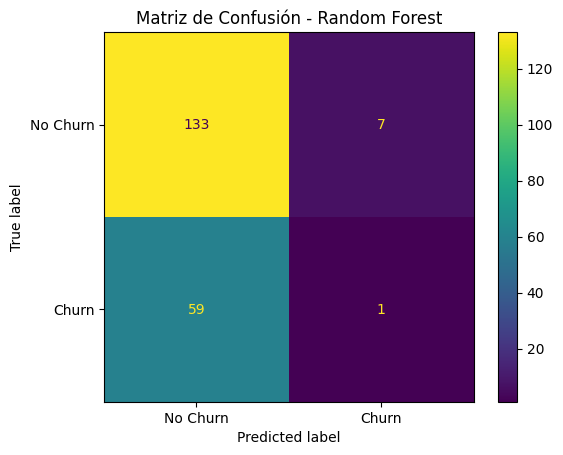

Accuracy: 0.6700
Precision: 0.1250
Recall: 0.0167
F1-score: 0.0294


In [27]:
# Evaluación del modelo Random Forest

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf_model.predict(X_test)

# Calcular métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Mostrar el reporte de clasificación
print("Reporte de Clasificación para Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Mostrar la matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['No Churn', 'Churn'])

print("Matriz de Confusión para Random Forest:")
disp_rf.plot()
plt.title('Matriz de Confusión - Random Forest')
plt.show()

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

Reporte de Clasificación para XGBoost:
              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75       140
         1.0       0.18      0.08      0.11        60

    accuracy                           0.61       200
   macro avg       0.43      0.46      0.43       200
weighted avg       0.53      0.61      0.56       200

Matriz de Confusión para XGBoost:


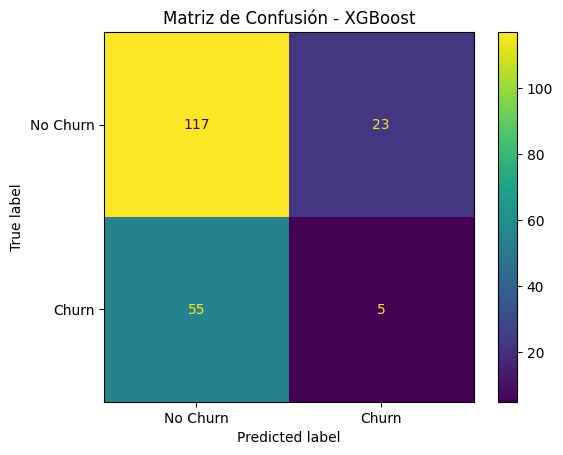

Accuracy: 0.6100
Precision: 0.1786
Recall: 0.0833
F1-score: 0.1136


In [28]:
# Evaluación del modelo XGBoost

# Realizar predicciones en el conjunto de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Calcular métricas de evaluación
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Mostrar el reporte de clasificación
print("Reporte de Clasificación para XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Mostrar la matriz de confusión
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Churn', 'Churn'])

print("Matriz de Confusión para XGBoost:")
disp_xgb.plot()
plt.title('Matriz de Confusión - XGBoost')
plt.show()

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")

### Importancia de las Variables (Feature Importance)

Analizamos la importancia de las variables en el modelo XGBoost para identificar qué características tienen mayor impacto en la predicción de la evasión de clientes.

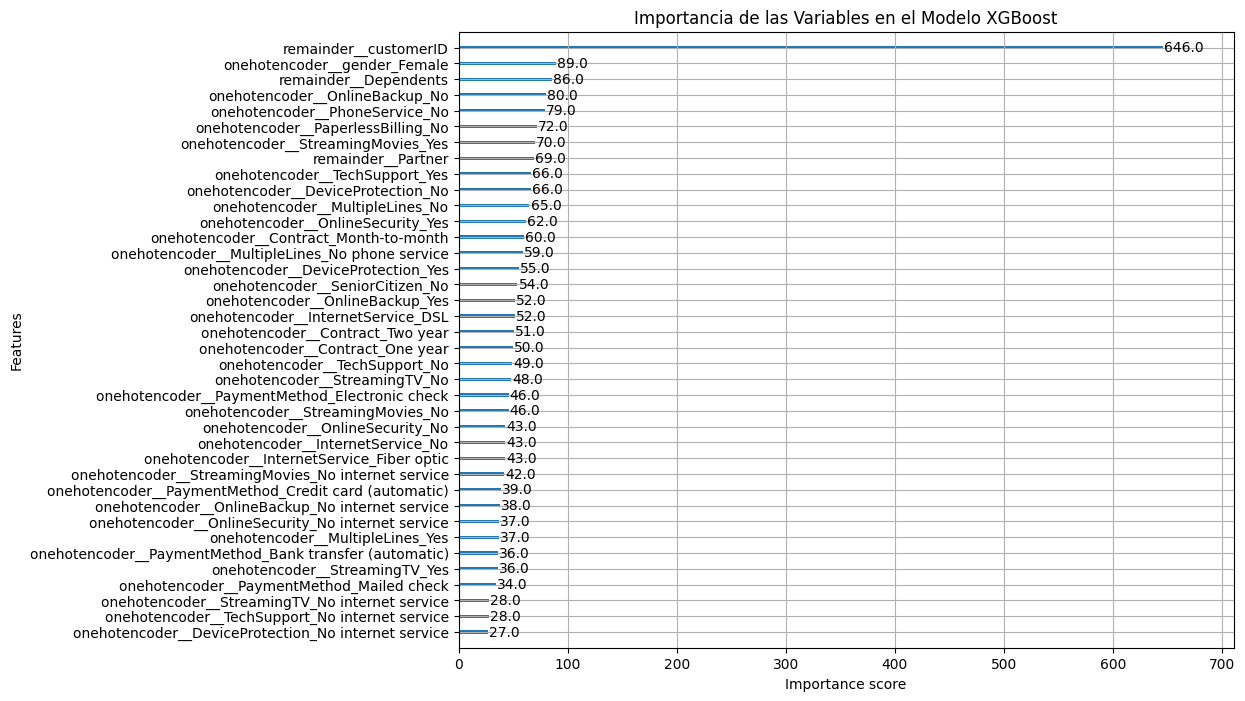

In [29]:
# Visualizar la importancia de las variables del modelo XGBoost
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_model, ax=ax)
plt.title('Importancia de las Variables en el Modelo XGBoost')
plt.show()

### Conclusión Estratégica y Hallazgos Clave

Después de entrenar y evaluar los modelos Random Forest y XGBoost, y analizar la importancia de las variables, podemos extraer las siguientes conclusiones estratégicas:

1.  **Rendimiento del Modelo:**
    *   Observando las métricas de evaluación en el conjunto de prueba (Precision, Recall, F1-score), podemos determinar cuál modelo se desempeñó mejor para identificar clientes propensos a la evasión. Considerar el contexto del negocio es crucial para decidir qué métrica es más importante (por ejemplo, un alto Recall es importante si queremos minimizar la pérdida de clientes, aunque esto signifique contactar a algunos clientes que no se irán).

2.  **Factores Clave de Evasión (Basado en la Importancia de Variables de XGBoost):**
    *   El análisis de importancia de variables de XGBoost nos mostró qué características tuvieron el mayor impacto en la predicción de churn. Los factores más importantes (como se ve en el gráfico de importancia) nos indican dónde la empresa debería enfocar sus esfuerzos para retener clientes. Por ejemplo, si el tipo de contrato, el servicio de Internet o el soporte técnico son muy importantes, la empresa podría considerar ofrecer incentivos para contratos más largos, mejorar la calidad del servicio de Internet o fortalecer el equipo de soporte técnico.

3.  **Recomendaciones Estratégicas:**
    *   Basándonos en los factores clave identificados, podemos proponer acciones específicas. Esto podría incluir campañas de retención dirigidas a segmentos de clientes con alto riesgo (según la predicción del modelo y las características importantes), mejoras en los servicios o la atención al cliente relacionados con las variables de alta importancia, o la revisión de las políticas de precios y contratos.

4.  **Próximos Pasos:**
    *   Aunque hemos desarrollado un pipeline inicial robusto, el proceso de modelado puede mejorarse aún más. Futuros pasos podrían incluir la exploración de otros modelos, la optimización más profunda de hiperparámetros utilizando `GridSearchCV`, la ingeniería de características adicionales, o la recolección de más datos si es posible.

En resumen, el modelo desarrollado (especialmente el que mejor se desempeñe) y el análisis de importancia de variables proporcionan información valiosa para que Telecom X pueda identificar proactivamente a los clientes en riesgo de evasión y tomar medidas estratégicas para retenerlos, lo que impactará positivamente en la rentabilidad de la empresa.